<center><h1>Neuroscience Final Project</h1></center>
<center><h2>Deep Q Networks</h2></center>

In this notebook, we are going to get familiar with Deep Q Networks. Deep Q Networks are an entension of Reinforcement Learning were we incorporate Deep Neural Networks in our policy enhacement procedure.

We also implement an Agent in an online learning environment, meaning that the agent has no initial memory of the rewards in each state. We go through the environment based on our policy and store the observed rewards and corresponding state in the memory of the agent

Finally, we utilize the Agent in a practical Maze Solving problem. The agent is prompted to iterate the maze from a defined starting point to an ending point, maximing the profit from the total route.

**Name** : Mahdi Gholizade Kalan

## Importing the necessary packages

In [1]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Creating the Deep Q Network

In [8]:
class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims,
                 n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*input_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.fc3 = nn.Linear(fc2_dims, n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        # Calculate the forward pass. Use Proper non-linear activation function between the linear layers
        outputsOne = F.relu(self.fc1(state))
        outputsTwo = F.relu(self.fc2(outputsOne))
        actions = self.fc3(outputsTwo)

        return actions

## Creating the Agent

In [11]:
class Agent:
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
                 max_mem_size=100000, eps_end=0.05, eps_dec=5e-4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        self.iter_cntr = 0
        self.eps_end = eps_end
        self.max_mem_size = 100000

        # Create an instance of te Deep Q network with 256 neurons in each of its hidden layers
        self.Q_eval = DeepQNetwork(lr, n_actions=n_actions, input_dims=input_dims, fc1_dims=256, fc2_dims=256)
        
        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool_)

    
    # Store one episode alongside its reward, state, next_state
    def store_transition(self, state, action, reward, state_, terminal):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = terminal

        self.mem_cntr += 1

    
    # Choose the best action with probability (1 - epsilon), otherwise choose a random direction from the action space
    # The best action is defined as the maximum output of the Deep Q Network
    def choose_action(self, observation):
        #Randomness of decision making
        probabilityOfdecision = np.random.random()
        probabilityRandomDecision = self.epsilon
        if probabilityOfdecision > probabilityRandomDecision:
            state = T.tensor([observation]).to(self.Q_eval.device)
            allActions = self.Q_eval.forward(state)
            action = T.argmax(allActions).item()
        else:
            action = np.random.choice(self.action_space)

        return action

    # Train the Deep Q Network based on the new observations
    # The network must learn the target Q values through regression
    def learn(self):
        # Simply ignore the training phase if there is not enough memory stored yet
        if self.mem_cntr < self.batch_size:
            return

        self.Q_eval.optimizer.zero_grad()

        # Choose a random batch of data from the memory
        maxMemory = min(self.mem_cntr, self.max_mem_size)
        batch = np.random.choice(maxMemory, self.batch_size, replace=False)
        batchIndex = np.arange(self.batch_size, dtype=np.int32)

        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)

        # Current state Q-value as predicted by the network
        # Note to filter the matrix to only q-values corresponding to our "action_batch"
        q_eval = self.Q_eval.forward(state_batch)[batchIndex, action_batch]

        # Next state Q-value as predicted by the network for all possible next actions
        q_next = self.Q_eval.forward(new_state_batch)
        q_next[terminal_batch] = 0.0

        # The target Q-value of our current state with a discount factor of gamma
        q_target = reward_batch + self.gamma * T.max(q_next, dim=1)[0]

        # Make the network learn this target Q-value via a proper definitio of loss function
        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()

        self.iter_cntr += 1

        # Reduce the epsilon by its decay factor it possible
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_end else self.eps_end

## Working with the Maze environment

In [18]:
from maze import MazeEnvironment
import warnings
warnings.filterwarnings('ignore')

# Create a maze environment
# You can create a new one or use the files stored in directory mazes to load a maze
env = MazeEnvironment(dim=50, maze_path='maze1.npy')

agent = Agent(gamma=0.99, epsilon=1.0, batch_size=2, n_actions=4, eps_end=0.01, input_dims=[2], lr=0.0001)
scores = []
averageScores = []
n_games = 50

for i in range(n_games):
    score = 0
    done = False
    observation = env.reset()
    counter = 0
    while not done:
        counter += 1
        # If performed 1000 moves and didn't finish the maze, reset the environment
        if (counter == 1000):
            counter = 0
            score = 0
            observation = env.reset()

        # Make the agent choose an action
        action = agent.choose_action(observation)

        # Retrieve the reward and next_state from the envirinment
        observation_, reward, done = env.step(action)
        
        score += reward

        # Store the current episode in the memory
        agent.store_transition(observation,action,reward,observation_,done)

        # Learn the current episode
        agent.learn()

        # Change the next state to the current state
        observation = observation_
        
    scores.append(score)

    avg_score = np.mean(scores[-100:])
    averageScores.append(avg_score)

    print('episode ', i, 'score %.2f' % score, 'average score %.2f' % avg_score, 'epsilon %.2f' % agent.epsilon)

episode  0 score 271.00 average score 271.00 epsilon 0.01
episode  1 score 67.00 average score 169.00 epsilon 0.01
episode  2 score 155.00 average score 164.33 epsilon 0.01
episode  3 score 188.00 average score 170.25 epsilon 0.01
episode  4 score 87.00 average score 153.60 epsilon 0.01
episode  5 score 83.00 average score 141.83 epsilon 0.01
episode  6 score 121.00 average score 138.86 epsilon 0.01
episode  7 score 898.00 average score 233.75 epsilon 0.01
episode  8 score 8634.00 average score 1167.11 epsilon 0.01
episode  9 score 3688.00 average score 1419.20 epsilon 0.01
episode  10 score 1535.00 average score 1429.73 epsilon 0.01
episode  11 score 1173.00 average score 1408.33 epsilon 0.01
episode  12 score 249.00 average score 1319.15 epsilon 0.01
episode  13 score 550.00 average score 1264.21 epsilon 0.01
episode  14 score 793.00 average score 1232.80 epsilon 0.01
episode  15 score 735.00 average score 1201.69 epsilon 0.01
episode  16 score 6446.00 average score 1510.18 epsilon 0

## Report

Try to manipulate constants such as batch_size, epsilon, gamma, .... Try to achieve the maximum score.

Grading will not be based on the best scores. However, higher scores can bring bonus grade!

Plot the incrementation of your score through n games and try to justify the patterns.

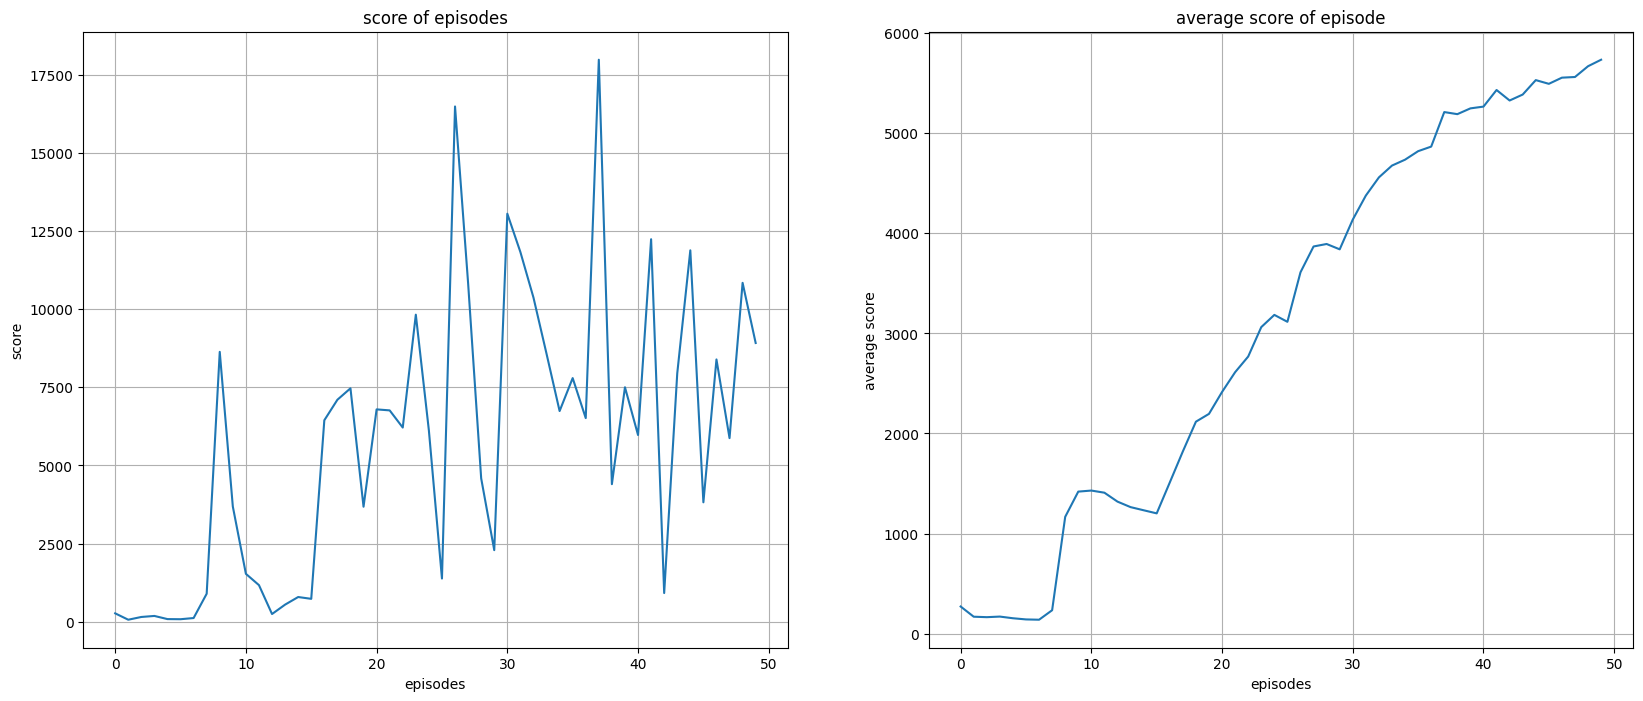

In [20]:
# Plotting score per episode (game)
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
plt.plot(scores)
plt.title('score of episodes')
plt.xlabel('episodes')
plt.grid()
plt.ylabel('score')

# Plotting average score per episode (game)
import matplotlib.pyplot as plt
plt.subplot(1,2,2)
plt.plot(averageScores)
plt.title('average score of episode')
plt.xlabel('episodes')
plt.ylabel('average score')
plt.grid()
plt.show()

## (Bonus) Target Q Network

Instead of calculating the target q-value using the formula presented, you can use anonther Deep Neural Network to predict the target Q-values via regression!

Implementing the target Q network alonside the eval Q network can lead to more steady behavior of the final score.